# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
# number of callbacks for black-sounding names
print(sum(data[data.race=='b'].call))

# number of callbacks for white-sounding names
print(sum(data[data.race=='w'].call))

157.0
235.0


In [4]:
print(data.shape)
data[['race', 'call']].head(10)

(4870, 65)


,race,call
0,w,0.0
1,w,0.0
2,b,0.0
3,b,0.0
4,w,0.0
5,w,0.0
6,w,0.0
7,b,0.0
8,b,0.0
9,b,0.0


In [5]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


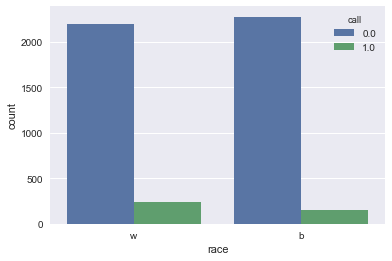

In [6]:
#checking distribution
sns.set()
sns.countplot(x='race',hue='call',data=data)
plt.show()

w = white sounding name

b = black sounding name

0.0 = no call back

1.0 = received call back

### What test is appropriate for this problem? Does CLT apply?

Bootstrap and z test hypothesis testing is appropriate here. We have a large sample size (n>30). We want to test the difference of proportions of black sounding names getting calls back versus white sounding names getting call backs. Central Limit Theorem does apply here, as we have a large sample size.

### What are the null and alternate hypotheses?

***Alternative Hypothesis: pw != pb***

There is a significant difference between the proportion of call backs for white sounding names versus black sounding names.

***Null Hypothesis: pw == pb***

There is NOT a significant difference between the proportion of call backs for white sounding names versus black sounding names.

In [7]:
w = data[data.race=='w']
b = data[data.race=='b']
w.call.astype(int)
b.call.astype(int)

def prop_calls(data):
    prop = sum(data) / len(data)
    return prop

pw = prop_calls(w.call)
pb = prop_calls(b.call)

print('prop for white sounding names: ', pw)
print('prop for black sounding names:', pb)

prop for white sounding names:  0.09650924024640657
prop for black sounding names: 0.06447638603696099


### Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.

#### Test Statistic

In [8]:
#margin of error
import math
z = 1.96
se = math.sqrt((pb*(1 - pb)/(len(b))) + (pw*(1 - pw) /(len(w))))

marg_err = z * se
print('Margin of Error: ', marg_err)

Margin of Error:  0.015255406349886438


In [9]:
#95% confidence interval
obs_diff = pw - pb
print('observed difference: ', obs_diff)
CI = [obs_diff - marg_err, obs_diff + marg_err]
print('95% Confidence Interval: ', CI)

observed difference:  0.032032854209445585
95% Confidence Interval:  [0.016777447859559147, 0.047288260559332024]


In [10]:
#z test
from statsmodels.stats.weightstats import ztest
tstat, pval = ztest(w.call, b.call)
print('P-value: ', pval)

P-value:  3.8767429116085706e-05


Based on the p-value we got and that we are doing a two sided hypothesis test, we **reject the null hypothesis**. There is a significant difference between the proportion of white sounding names receiving calls versus black sounding names. We will repeat this test through bootstrapping.

#### Bootstrap testing

In [11]:
#draw bs replicates func
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty([size])
    
    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [24]:
#95% confidence interval
prop_call = sum(data.call) / len(data.call)
print('Total proportion of callbacks: ', prop_call)

shifted_b = b.call - pb + prop_call
shifted_w = w.call - pw + prop_call

bs_replicates_b = draw_bs_reps(shifted_b, prop_calls, 10000)
bs_replicates_w = draw_bs_reps(shifted_w, prop_calls, 10000)
bs_replicates = bs_replicates_w - bs_replicates_b

p = np.sum(bs_replicates >= obs_diff) / 10000
print("P-value: %2.9F" % (p))

Total proportion of callbacks:  0.08049281314168377
P-value: 0.000000000


### Write a story describing the statistical significance in the context or the original problem.

In this analysis, we aimed to determine if there is a significant difference between the proportion of black sounding names receiving callbacks and that of white sounding names receiving callbacks. We are 95% confident that the population difference of proportions between black sounding and white sounding names receiving callbacks is between 0.0167 and 0.0473. Because a difference of 0 does not lie within the confidence interval, we can see that there is a significant difference between the proportions. If a difference of 0 did lie within the interval, than there would be a possibility that there was no difference. Conclusively, through our Z test, we got a p-value of 3.876e-05, which is extremely low. This indicates that this difference between the proportions is very significant. 

Through a z test and a bootstrap test, we've concluded that **there is a significant difference between the two**. ***White sounding names receive significantly more callbacks than black sounding names***. This gives us more insight into racial discrimination in the labor market. 

### Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

Although we've shown that the proportion of white sounding names receiving callbacks is significantly greater than that of black sounding names receiving callbacks, it does not show that race/name is the most important factor. We would need to do much further in-depth analysis in order to determine if it is, by taking a look at the relationship between multiple other variables and callbacks. Then compare these relationships with race. These results show a *correlation* but not enough to talk about *causation*. Variables i.e. education, years of experience, etc. would need to be looked at.